## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import copy

from network import ConvNetBig, ConvNetSmall

In [2]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
net = ConvNetBig()
# net = ConvNetSmall()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.005)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
net.to(device)

ConvNetBig(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
# from torchsummary import summary
# summary(net, input_size=(3, 32, 32))

In [8]:
def get_accuracy(model, dataloader):
    total = 0
    correct = 0
    for (images, labels) in iter(dataloader):
        images, labels = images.to(device), labels.to(device)
        predicted = model.predict(images)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [9]:
epochs = 10
running_loss = 0
print_every = 100
best_accuracy_val = 0
best_model = None
nb_steps = len(trainloader)
accuracy_val = []
accuracy_tr = []
losses = []

for e in range(epochs):
    start = time.time()
    
    for step, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if step % print_every == 0: # Test accuracy
            net.eval()
            with torch.no_grad():

                accuracy_tr.append(get_accuracy(net, trainloader))
                accuracy_val.append(get_accuracy(net, valloader))
                
                if accuracy_val[-1] > best_accuracy_val: # Save best model
                    best_model = copy.deepcopy(net)
                    best_accuracy_val = accuracy_val[-1]
                    

                print("Epoch: {}/{}".format(e+1, epochs),
                      "Step: {}/{}".format(step, nb_steps),
                      "Loss: {:.4f}..".format(running_loss/print_every),
                      "Train accuracy: {:.3f}..".format(accuracy_tr[-1]),
                      "Test accuracy: {:.3f}..".format(accuracy_val[-1]),
                      "{:.3f} s/{} steps".format((time.time() - start), print_every)
                     )
            losses.append(running_loss/print_every)
            running_loss = 0
            start = time.time()
            
print("Best reached accuracy was {}".format(best_accuracy_val))

Epoch: 1/10 Step: 0/766 Loss: 0.0230.. Train accuracy: 10.302.. Test accuracy: 11.000.. 32.338 s/100 steps
Epoch: 1/10 Step: 100/766 Loss: 1.9045.. Train accuracy: 38.500.. Test accuracy: 38.500.. 22.874 s/100 steps
Epoch: 1/10 Step: 200/766 Loss: 1.5903.. Train accuracy: 42.773.. Test accuracy: 42.400.. 20.807 s/100 steps
Epoch: 1/10 Step: 300/766 Loss: 1.4314.. Train accuracy: 50.071.. Test accuracy: 47.900.. 20.726 s/100 steps
Epoch: 1/10 Step: 400/766 Loss: 1.3712.. Train accuracy: 54.043.. Test accuracy: 53.800.. 20.969 s/100 steps
Epoch: 1/10 Step: 500/766 Loss: 1.3215.. Train accuracy: 54.733.. Test accuracy: 53.400.. 22.451 s/100 steps
Epoch: 1/10 Step: 600/766 Loss: 1.2545.. Train accuracy: 56.551.. Test accuracy: 56.300.. 23.551 s/100 steps
Epoch: 1/10 Step: 700/766 Loss: 1.2257.. Train accuracy: 58.288.. Test accuracy: 57.200.. 21.600 s/100 steps
Epoch: 2/10 Step: 0/766 Loss: 0.7800.. Train accuracy: 59.184.. Test accuracy: 58.800.. 27.183 s/100 steps
Epoch: 2/10 Step: 100/7

Epoch: 10/10 Step: 300/766 Loss: 0.6932.. Train accuracy: 77.941.. Test accuracy: 76.400.. 22.040 s/100 steps
Epoch: 10/10 Step: 400/766 Loss: 0.6884.. Train accuracy: 78.504.. Test accuracy: 74.800.. 20.988 s/100 steps
Epoch: 10/10 Step: 500/766 Loss: 0.6696.. Train accuracy: 78.929.. Test accuracy: 74.600.. 21.851 s/100 steps
Epoch: 10/10 Step: 600/766 Loss: 0.7341.. Train accuracy: 77.337.. Test accuracy: 73.400.. 21.099 s/100 steps
Epoch: 10/10 Step: 700/766 Loss: 0.6926.. Train accuracy: 77.918.. Test accuracy: 74.600.. 21.036 s/100 steps
Best reached accuracy was 77.1


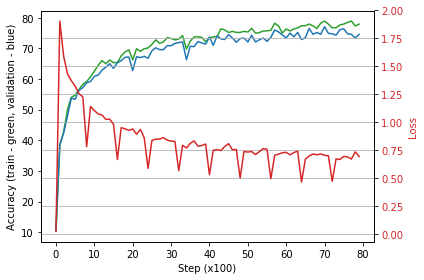

In [10]:
fig, ax1 = plt.subplots()

color_tr = 'tab:green'
color_val = 'tab:blue'
ax1.set_xlabel("Step (x100)")
ax1.set_ylabel("Accuracy (train - green, validation - blue)")
ax1.plot(range(len(accuracy_tr)), accuracy_tr, color=color_tr)
ax1.plot(range(len(accuracy_tr)), accuracy_val, color=color_val)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_loss = 'tab:red'
ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
ax2.plot(range(len(losses)), losses, color=color_loss)
ax2.tick_params(axis='y', labelcolor=color_loss)

fig.tight_layout()
plt.grid()
plt.show()

Save best trained model.

In [11]:
model_name = "model.ckpt"

In [12]:
torch.save(best_model.state_dict(), model_name)

Test that saved correctly

In [13]:
checkpoint = torch.load(model_name)
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [14]:
get_accuracy(net, trainloader), get_accuracy(net, valloader)

(78.92857142857143, 77.1)